In [53]:
# Shanshank

from scipy.special import expit
import scipy.optimize
from scipy.optimize import minimize #, differential_evolution
import numpy as np
from math import sin,cos
#xarr=var('xarr')
x=np.linspace(0,2,11)
#x=np.array([1.0])
hvar=5
numeqs=4
omega=1.0
theta=1.0
bounds=np.zeros([3*4*5,2])
for i in range(3*4*5):
    bounds[i,0]=-5
    bounds[i,1]=5
partot=np.array(np.zeros(3*hvar*numeqs))
x0=[1.0,0.0,0.0,0.0]
#par = par.reshape(3,hvar)
print partot
print x
one=np.ones(hvar)

def sig(x,par):
    ans=[]
    par1 = par.reshape(3,hvar)
    #print "test", par[2]
    for i in x:
        ans.append(expit(i*par1[1,:]+par1[2,:]))
        #ans.append(np.tanh(i*par1[1,:]+par1[2,:]))
    return ans
def N(x,par):
    par1=par.reshape(3,hvar)
    ans=np.inner(par1[0,:],sig(x,par))
    return ans
def y(x,par,xini):
    return xini+x*N(x,par)
def dNdx(x,par):
    par1=par.reshape(3,hvar)
    ans=np.zeros(len(x))
    #print len(x)
    for j in range(len(x)):
        for i in range(hvar):
            ans[j]=ans[j]+(par1[0,i])*(sig(x,par)[j][i])*((one-sig(x,par))[j][i])*par1[1,i]
    return(ans)
def dydx(x,par):
    return N(x,par)+x*dNdx(x,par)
def yp(partot):
    partot1=partot.reshape((numeqs,3,hvar))
    cost=0.0
    cost=cost+np.sum(0.5*(dydx(x,partot1[0,:,:])-2*omega*sin(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[1,:,:])+2*omega*sin(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[2,:,:])-2*omega*cos(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[3,:,:])+2*omega*cos(2*theta)*y(x,partot1[2,:,:],x0[2])+omega*sin(2*theta)*y(x,partot1[0,:,:],x0[0])-omega*sin(2*theta)*y(x,partot1[1,:,:],x0[1]))**2)
    cost = cost#+np.sum((y(x,partot1[0,:,:],x0[0])+y(x,partot1[1,:,:],x0[1])-1.0)**2)


    return cost
#def ypprime(par): 
#vout=minimize(yp,par,method='COBYLA',options={"maxfev": 10000})
#vout=minimize(yp,partot,method='SLSQP',options={"maxiter": 1000})
#vout=minimize(yp,partot,method='Nelder-Mead',tol=1e-5,options={"ftol":1e-3, "maxfev": 1000000,"maxiter":1000000})
#vout=differential_evolution(yp,bounds,strategy='best1bin',tol=0.1,maxiter=1,polish=True)
#print vout


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2. ]


In [61]:
# Here is the activation function

def act(x):
    return expit(x)

# Density matrix in the forms that I wrote down on my Neutrino Physics notebook
# x is a real array of 12 arrays.

init = np.array([1.0,0.0,0.0,0.0])

def rho2(x,ti,initialCondition):
    
    elem = np.ones(4)
    
    for i in np.linspace(0,3,4):
        elem[i] = np.sum(ti*x[i*3]*act(ti*x[i*3+1] + x[i*3+2]) )
    
    return init + elem
    
# Hamiltonian of the problem, in terms of four real components

hamil = np.array( [  np.cos(2.0),np.sin(2.0) , np.sin(2.0),np.cos(2.0) ] )

# Cost function for each time step

def rhop(x,ti,initialCondition):
    
    rhoprime = np.zeros(4)
    
    for i in np.linspace(0,3,4):
        rhoprime[i] = np.sum(x[i*3] * (act(ti*x[i*3+1] + x[i*3+2]) ) ) +  np.sum( ti*x[i*3]* (act(ti*x[i*3+1] + x[i*3+2]) ) * (1.0 - (act(ti*x[i*3+1] + x[i*3+2])  ) )* x[i*3+1]  )
        
    return rhoprime


## This is the regularization

regularization = 0.0001

def costi(x,ti,initialCondition):
    
    rhoi = rho2(x,ti,initialCondition)
    rhopi = rhop(x,ti,initialCondition)
    
    costTemp = np.zeros(4)
    
    costTemp[0] = ( rhopi[0] - 2.0*rhoi[3]*hamil[1] )**2
    costTemp[1] = ( rhopi[1] + 2.0*rhoi[3]*hamil[1] )**2
    costTemp[2] = ( rhopi[2] - 2.0*rhoi[3]*hamil[0] )**2
    costTemp[3] = ( rhopi[3] + 2.0*rhoi[2]*hamil[0] - hamil[1] * (rhoi[1] - rhoi[0] ) )**2
    
    return np.sum(costTemp)# + 2.0*(rhoi[0]+rhoi[1]-1.0)**2

    
#    return np.sum(costTemp) + regularization*np.sum(x**2)
    
def cost2(x,t,initialCondition):
    
    costTotal = map(lambda t: costi(x,t,initialCondition),t)

    return 0.5*np.sum(costTotal)

In [62]:
array12 = np.asarray(np.split(np.random.rand(2,60)[0],12))
#array12 = np.asarray(np.split(np.ones(60),12))

ssfun11 = y(np.array([2.0]),array12.reshape((numeqs,3,hvar))[1,:,:],x0[1])
mifun11 = rho2(array12,2,init)[1]
print mifun11, ssfun11, ssfun11/mifun11 ## Good we have the same function values

2.36779048927 [ 2.36779049] [ 1.]


In [63]:
# rho prime
index=3
mirhop=rhop(array12,1,init)
ssrhop=dydx(x,array12.reshape((numeqs,3,hvar))[index,:,:])
print mirhop, ssrhop
## OK we have exactly the same rho prime.

[ 1.89300839  1.21239164  2.6472061   1.35053111] [ 1.08430389  1.14225019  1.19834742  1.25202231  1.30284305  1.35053111
  1.39495512  1.43611112  1.47409488  1.50907187  1.54124914]


In [64]:
mine = cost2(array12,x,init)
ss = yp(array12)
print mine, ss, ss/mine
#cost(xresult,np.array([0,4,11]),init)

179.054795807 179.054795807 1.0


In [65]:
print hamil

[-0.41614684  0.90929743  0.90929743 -0.41614684]


In [66]:
np.cos(2)

-0.41614683654714241

In [67]:






# with ramdom initial guess

#initGuess = np.asarray(np.split(np.random.rand(5,60)[0],12))
initGuess = costvFResultSLSQP.get("x")
#initGuess = np.split(np.zeros(60),12)
endpoint = 2
tlin = np.linspace(0,endpoint,11)

costF = lambda x: cost2(x,tlin,init)

costvFResultSLSQP = minimize(costF,initGuess,method='Nelder-Mead',tol=1e-8,options={"ftol":1e-4, "maxfev": 1000000,"maxiter":100000})

print costvFResultSLSQP

  status: 0
    nfev: 2507
 success: True
     fun: 0.50474543317598686
       x: array([ -3.17229685e-01,   7.34397608e+00,  -1.43011129e+00,
         3.72770431e-01,  -1.73499584e+00,   5.04445327e+00,
         2.22989797e-01,  -1.10447929e+00,   2.60460515e+00,
        -1.39316207e+00,  -1.65676387e+00,   1.29597663e-01,
         1.31898241e+01,  -1.88713119e+00,  -3.52229266e+00,
         6.18893398e+00,  -4.63152878e+00,   1.85131876e+01,
         8.26037642e+00,   8.68019718e+00,  -2.56127154e+00,
        -3.37957483e+01,   6.58247961e+01,   3.33762546e+01,
         7.15065759e+00,   1.87731000e+01,  -5.49793597e+01,
         3.84908198e+00,   3.70515383e+01,   5.39705952e+01,
        -1.15527045e+00,  -9.68071876e+00,  -2.41236115e+01,
         6.29279538e+00,  -2.56500227e+00,   8.27152854e+00,
        -8.79001606e+00,   4.29621262e+00,   4.16474705e+00,
         7.98748614e-01,  -4.10778718e+01,  -3.93066291e+01,
        -3.80935826e+01,  -1.93985877e+01,   4.61668908e+01,
   

[ 1.          0.98859976  0.96467298  0.92900482  0.88773165  0.84648289
  0.80742997  0.77053421  0.73514088  0.70065697  0.66668584  0.63299239
  0.59944549  0.56597458  0.53254258  0.49913029  0.46572791  0.43233048
  0.3989355   0.36554174]


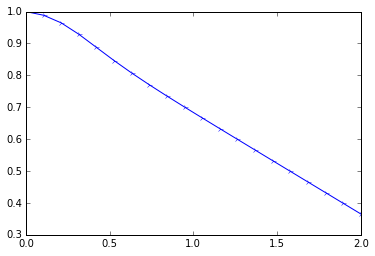

In [68]:
xresult = costvFResultSLSQP.get("x")
plttlin=np.linspace(0,endpoint,20)
pltdata11 = np.array([])
for i in plttlin:
    pltdata11 = np.append(pltdata11 ,(rho2(xresult,i,init)[0] ) )
    
print pltdata11

ss11 = y(plttlin,xresult.reshape((numeqs,3,hvar))[0,:,:],x0[0])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()

In [69]:
print ss11

[ 1.          1.25931194  1.52472062  1.79501066  2.07106854  2.35592218
  2.65321972  2.9655081   3.29357741  3.63678744  3.9937117   4.36268279
  4.74213674  5.13078419  5.52766144  5.9321093   6.34371712  6.76225726
  7.18762491  7.61978964]
